<a href="https://colab.research.google.com/github/Laoode/SentiFeedback/blob/Agus_Workspace/Modeling_Sentiment_Bahasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [3]:
!pip install sastrawi
!pip install emoji

In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import string
import emoji
import re
import pandas as pd
import numpy as np
from nltk import FreqDist
from wordcloud import WordCloud
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense,  Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load Dataset

In [4]:
path = '/content/dataset_translated_id.csv'

df = pd.read_csv(path)
df.head()

,Id,Komentar,Rating
0,45881,"Rand adalah pria yang baik, sungguh ... dia.Ta...",Sangat Buruk
1,45881,"Dia brilian di bidangnya, tetapi mengharapkan ...",Buruk
2,45881,Dia memiliki jurusan filsafat itulah sebabnya ...,Sangat Buruk
3,45881,Saya pikir kelasnya sangat sulit tetapi terlep...,Baik
4,45881,Baru -baru ini saya baru saja selesai mengambi...,Buruk


# Preparation

In [6]:
df.shape

(2314, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        2314 non-null   object
 1   Komentar  2314 non-null   object
 2   Rating    2312 non-null   object
dtypes: object(3)
memory usage: 54.4+ KB


In [8]:
df.Rating.value_counts()

,count
Rating,
Sangat Baik,397
Sangat Buruk,322
Baik,296
Cukup Baik,272
Buruk,259
awesome,220
awful,159
good,149
poor,130


In [9]:
map = {
    'awesome': 'Sangat Baik',
    'good': 'Baik',
    'average': 'Cukup Baik',
    'poor': 'Buruk',
    'awful': 'Sangat Buruk'
}

df['Rating'] = df['Rating'].replace(map)
df['Rating'].value_counts()

,count
Rating,
Sangat Baik,617
Sangat Buruk,481
Baik,445
Buruk,389
Cukup Baik,380


In [10]:
df['Rating'] = df['Rating'].replace(
    {
        'Sangat Baik': 'Baik',
        'Sangat Buruk': 'Buruk',
        'Cukup Baik': 'Baik'
    }
)

In [11]:
df['Rating'].value_counts()

,count
Rating,
Baik,1442
Buruk,870


# Preprocessing

In [12]:
df.isnull().sum()

,0
Id,0
Komentar,0
Rating,2


Mengisi pakai modus

In [13]:
df['Rating'].fillna(df['Rating'].mode()[0], inplace=True)

In [14]:
df.drop('Id', axis=1, inplace=True) #Hapus Kolom Id

In [15]:
def casefolding(content):
  content = content.lower()
  return content

df['Komentar'] = df['Komentar'].apply(lambda x: casefolding(x))
df.head()

,Komentar,Rating
0,"rand adalah pria yang baik, sungguh ... dia.ta...",Buruk
1,"dia brilian di bidangnya, tetapi mengharapkan ...",Buruk
2,dia memiliki jurusan filsafat itulah sebabnya ...,Buruk
3,saya pikir kelasnya sangat sulit tetapi terlep...,Baik
4,baru -baru ini saya baru saja selesai mengambi...,Buruk


In [16]:
def cleaning(content):
  content = content.strip(' ') # Hapus spasi di awal dan di akhir
  content = re.sub(r'\d+', '', content) # Hapus angka
  content = content.translate(str.maketrans('','', string.punctuation)) # Hapus punctuation
  content = re.sub(r'\b[a-zA-Z]\b', '', content) # Regex untuk hapus kata yang berisi satu huruf
  content = re.sub(r'\s+', ' ', content) # Hapus spasi berlebih
  return content

df['Komentar'] = df['Komentar'].apply(lambda x: cleaning(x))
df.head()

,Komentar,Rating
0,rand adalah pria yang baik sungguh diatapi say...,Buruk
1,dia brilian di bidangnya tetapi mengharapkan m...,Buruk
2,dia memiliki jurusan filsafat itulah sebabnya ...,Buruk
3,saya pikir kelasnya sangat sulit tetapi terlep...,Baik
4,baru baru ini saya baru saja selesai mengambil...,Buruk


In [18]:
#Hapus emoji
def emoji_removal(content):
  content = emoji.replace_emoji(content, replace='')
  return content

df['Komentar'] = df['Komentar'].apply(lambda x: emoji_removal(x))
df.head()

,Komentar,Rating
0,rand adalah pria yang baik sungguh diatapi say...,Buruk
1,dia brilian di bidangnya tetapi mengharapkan m...,Buruk
2,dia memiliki jurusan filsafat itulah sebabnya ...,Buruk
3,saya pikir kelasnya sangat sulit tetapi terlep...,Baik
4,baru baru ini saya baru saja selesai mengambil...,Buruk


In [20]:
#Hapus icon emoji
def remove_emoticons(content):
    emoticon_pattern = re.compile(r"""
        (?::|;|=) # Kolom, titik koma, dan tanda seperti wajah
        (?:-)? # Tanda minus
        (?:\)|\(|D|P|O|/|\|S) # char yang seperti ekspresi
        """, re.VERBOSE)

    return emoticon_pattern.sub(r'', content)

df['Komentar'] = df['Komentar'].apply(lambda x: remove_emoticons(x))
df.head()

,Komentar,Rating
0,rand adalah pria yang baik sungguh diatapi say...,Buruk
1,dia brilian di bidangnya tetapi mengharapkan m...,Buruk
2,dia memiliki jurusan filsafat itulah sebabnya ...,Buruk
3,saya pikir kelasnya sangat sulit tetapi terlep...,Baik
4,baru baru ini saya baru saja selesai mengambil...,Buruk


In [21]:
#Stopword Sastrawi
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()

def stopwords(content):
  content = ' '.join([word for word in content.split() if word not in sastrawi_stopwords])
  return content

df['Komentar'] = df['Komentar'].apply(lambda x: stopwords(x))
df.head()

,Komentar,Rating
0,rand pria baik sungguh diatapi merasa memiliki...,Buruk
1,brilian bidangnya mengharapkan murid muridnya ...,Buruk
2,memiliki jurusan filsafat sebabnya semua makal...,Buruk
3,pikir kelasnya sangat sulit terlepas semua men...,Baik
4,baru baru baru selesai mengambil comp rand kel...,Buruk


In [22]:
#Encoding Fitur
le = LabelEncoder()
df['Rating'] = le.fit_transform(df['Rating'])
df.head()

,Komentar,Rating
0,rand pria baik sungguh diatapi merasa memiliki...,1
1,brilian bidangnya mengharapkan murid muridnya ...,1
2,memiliki jurusan filsafat sebabnya semua makal...,1
3,pikir kelasnya sangat sulit terlepas semua men...,0
4,baru baru baru selesai mengambil comp rand kel...,1


In [23]:
le.classes_

array(['Baik', 'Buruk'], dtype=object)

In [24]:
# tokenisasi teks
max_fatures = 2000

tokenizer = Tokenizer(num_words=max_fatures, split=' ',)
tokenizer.fit_on_texts(df['Komentar'])

# konversi teks ke sequence
sequences = tokenizer.texts_to_sequences(df['Komentar'])

# padding sequences
padded_sequences = pad_sequences(sequences, maxlen=100)

# Modeling

In [25]:
#labeling
X = padded_sequences
y = df['Rating']

In [26]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# cek bentuk data
print(f'Shape of X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}, y_test: {y_test.shape}')

Shape of X_train: (1851, 100), y_train: (1851,)
Shape of X_test: (463, 100), y_test: (463,)


In [43]:
# inisialisasi model
model = Sequential([
    Embedding(max_fatures, 128, input_length=len(padded_sequences[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')  # Outputnya 1 aja pakai aktivasi sigmoid
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, len(padded_sequences[1])))
# summary model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 527,489 (2.01 MB)

 Trainable params: 527,489 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# training
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step - accuracy: 0.6169 - loss: 1.3541 - val_accuracy: 0.6544 - val_loss: 0.8970
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - accuracy: 0.7311 - loss: 0.7642 - val_accuracy: 0.7171 - val_loss: 0.6529
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 409ms/step - accuracy: 0.8434 - loss: 0.4668 - val_accuracy: 0.7603 - val_loss: 0.5578
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.9017 - loss: 0.3064 - val_accuracy: 0.7473 - val_loss: 0.5907
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.9328 - loss: 0.2144 - val_accuracy: 0.7451 - val_loss: 0.6450
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.9429 - loss: 0.1601 - val_accuracy: 0.7538 - val_loss: 0.6528


# Evaluasi

In [29]:
# evaluasi model training
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Loss: {loss}, Accuracy: {accuracy}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.8945 - loss: 0.3186
Loss: 0.30780029296875, Accuracy: 0.9000540375709534


In [30]:
# evaluasi model test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.7627 - loss: 0.5817
Loss: 0.5578135251998901, Accuracy: 0.7602591514587402


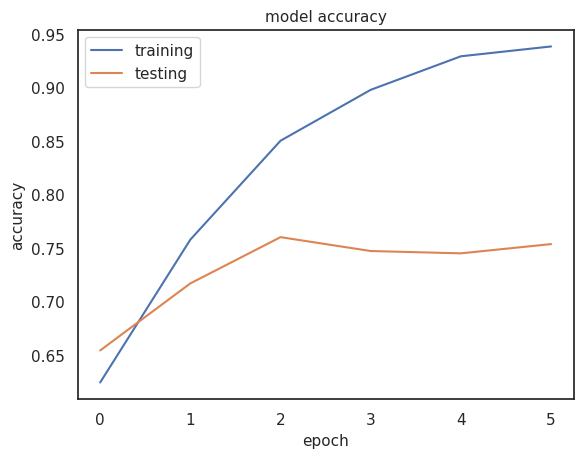

In [31]:
# plot history
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='testing')
plt.title('model accuracy', fontsize=11)
plt.ylabel('accuracy', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend()
plt.show()

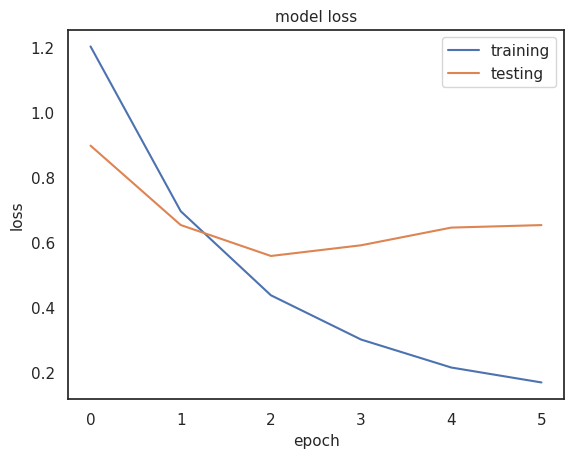

In [32]:
# plot history loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.title('model loss', fontsize=11)
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend()
plt.show()

In [42]:
def predict_rating(comment):
    comment_cleaned = cleaning(comment)
    comment_cleaned = stopwords(comment_cleaned)
    comment_cleaned = remove_emoticons(comment_cleaned)
    comment_cleaned = emoji_removal(comment_cleaned)
    comment_cleaned = casefolding(comment_cleaned)

    sequence = tokenizer.texts_to_sequences([comment_cleaned])
    padded_sequence = pad_sequences(sequence, maxlen=100)

    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction, axis=1)[0]
    predicted_rating = le.inverse_transform([predicted_label])[0]

    return predicted_rating

new_comment = "Pelajaran ini sangat bagus dan berkualitas."
predicted_rating = predict_rating(new_comment)
print(f"Predicted Rating: {predicted_rating}")


new_comment1 = "Hindari kelas ini"
predicted_rating1 = predict_rating(new_comment1)
print(f"Predicted Rating: {predicted_rating1}")

new_comment2 = "Cukup baik dalam menjelaskan dan kuharap lebih baik."
predicted_rating2 = predict_rating(new_comment2)
print(f"Predicted Rating: {predicted_rating2}")

new_comment3 = "tidak peduli dengan muridnya ini sangat buruk"
predicted_rating3 = predict_rating(new_comment3)
print(f"Predicted Rating: {predicted_rating3}")


new_comment4 = "Aku sangat senang bisa diajar. ini pengalaman yang menarik"
predicted_rating4 = predict_rating(new_comment4)
print(f"Predicted Rating: {predicted_rating4}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted Rating: Baik
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted Rating: Baik
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Rating: Baik
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Rating: Baik
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Rating: Baik
